# Field data processing and inversion
In this notebook will be feature the different processing and filtering function of the EMagPy Python API.
> To get help on any method run `help(k.forward)` for instance

In [3]:
# adding the source path of emagpy to the PATH (only needed when run from source)
import sys

sys.path.append("../src/")

# import modules
from emagpy import Problem

## Cover Crop Dataset
The data were collected using a CMD Mini-Explorer on plots sown with different cover crops in 2018 at Nottingham Sutton Bonington Campus (UK). The field in which the experiment took place had a slope and the first plot was situated at the bottom of the slope where higher clay content (higher EC) has been observed. Subsequent measurement where taken going up the slope to more sandy areas (lower EC).

## Importing data

First we can to specify the directory of the data, then the data can be imported using `createSurvey()` and displayed using `show()`.

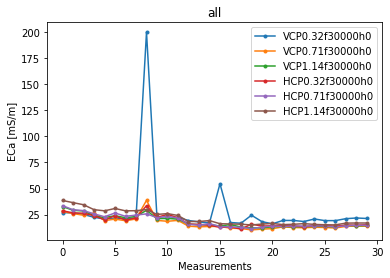

In [2]:
datadir = "../src/examples/cover-crop/"

k = Problem()
k.createSurvey(datadir + "coverCropTransect.csv")
k.show(coil="all")

## Data filtering

It is evident that there are some outliers within the data. We can remove such data by applying a maximum/minimum filter:

`k.filterRange(0, 40)` #where minimum and maximum ECa values need to be specified.

Following from this we can also do a running average of the data:

`k.rollingMean(n)` # running average over every n measurements

Filter the Cover Crop dataset and plot the results to see what has happened.

The data of individual coils can be plotted by specifying the coil name in `k.show()`: `k.show(coil='VCP0.32)`

2/30 data removed (filterRange).
dataset shrunk of 2 measurements


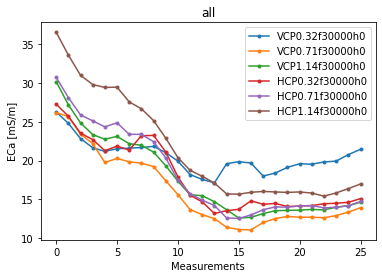

In [3]:
k.filterRange(0, 40)  # supply min and max bounds for ECa values for filtering
k.rollingMean(3)  # running average over every 3 measurements
k.show(coil="all")  # show data, specify coil to plot and y limits

## Inversion

As a first attempt we will perform a smooth inversion to look at the general distribution of EC with depths.

For this we must specify an array of depths to be fixed in the initial model:

`k.setInit(depths0=np.array([0.25, 0.5, 0.75, 1, 1.5, 2]))` # depth bottom of layer in meters

We also need to introduce smoothing into the model using an alpha value:

`k.invert(method='L-BFGS-B', alpha=0.07, regularization='l1')`

In [4]:
k.setInit(
    depths0=[0.25, 0.5, 0.75, 1, 1.5, 2],
    fixedDepths=[True, True, True, True, True, True],
    conds0=[20, 20, 20, 20, 20, 20, 20],
    fixedConds=[False, False, False, False, False, False, False],
)

k.invert(
    method="L-BFGS-B", forwardModel="CS", alpha=0.07, regularization="l1", njobs=-1
)

  4%|▍         | 1/26 [00:00<00:02,  8.65it/s]

Survey 1/1


100%|██████████| 26/26 [00:05<00:00,  4.78it/s]


The inverted model can be displayed using `k.showResults()` and the quality of the inversion can be assessed using `k.showMisfit()` and `k.showOne2one()`.

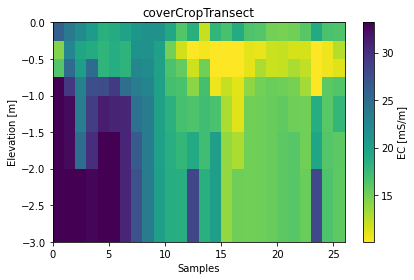

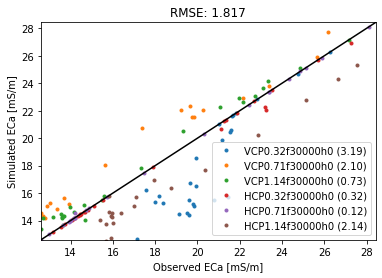

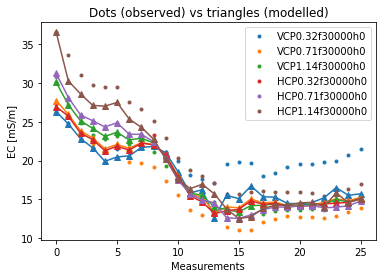

In [5]:
k.showResults()  # inverted EC model
k.showOne2one()  # modelled ECa vs observed ECa
k.showMisfit()  # modelled ECa and observed ECa plotted on same axis

## Challenge 1: landslide
Import the Hollin Hill dataset (`../src/examples/hollin-hill/dfm-expl.csv`) and filter the data. The potatoes dataset contains spatial data that can be used to display a map of ECa for each coil. Try it by running: `k.showMap()` to display the ECa values for each coil.

In addition the colour scale can be specified using `cmap=` (e.g. `'viridis`, `'viridis_r'`, `'jet'`)

Using the help from `help(k.showMap)`, try to plot a contour map of the ECa.

Then invert the data using the same smooth model as previously but use `CSgn` as `forwardModel`. This will make use of the fast Gauss-Newton implementation. No method needs to be specified.

You can display the the inverted EC per depth using the `k.showSlice()` function. Compare it the map of ECa previously plotted.

dataset shrunk of 4 measurements
Survey 1/1
1256/1256 inverted


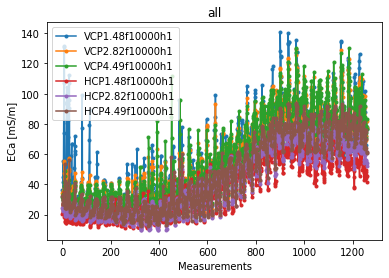

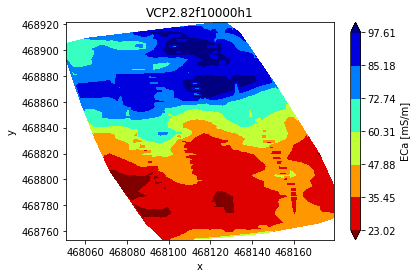

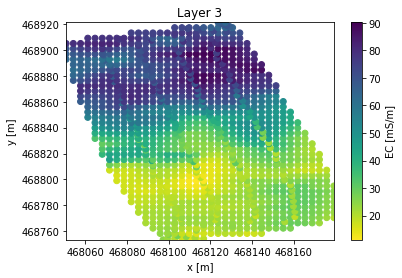

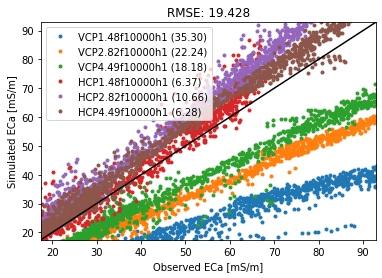

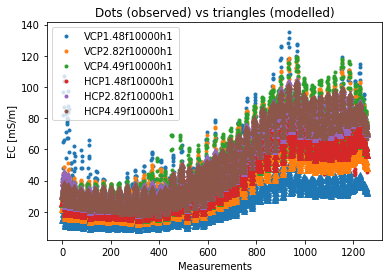

In [23]:
# ANSWER
k = Problem()
k.createSurvey("../src/examples/hollin-hill/dfm-expl.csv")
k.show(coil="all")
k.rollingMean(5)
k.showMap(coil=k.coils[1], contour=True, cmap="jet_r")
k.invert(forwardModel="CSgn", alpha=0.07, regularization="l1")
k.setInit(
    depths0=[0.5, 1, 1.5, 2, 3, 4],
    fixedDepths=[True, True, True, True, True, True],
    conds0=[20, 20, 20, 20, 20, 20, 20],
    fixedConds=[False, False, False, False, False, False, False],
)
k.showSlice(islice=2)
k.showOne2one()
# k.showMisfit()

## Challenge 2: sharp inversion
Import the cover crop dataset again and perform the needed filtering. Then invert it on a two layers model using the `ROPE` solver and allowing a variable depth of the first layer.

  0%|          | 0/30 [00:00<?, ?it/s]

Survey 1/1


100%|██████████| 30/30 [00:03<00:00,  8.91it/s]


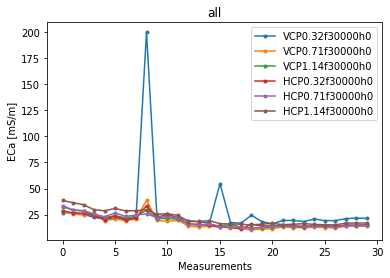

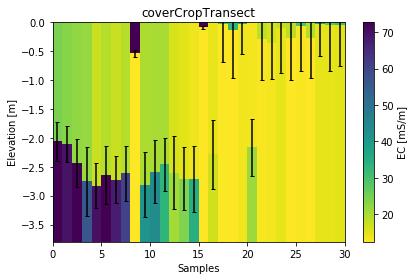

In [27]:
# ANSWER
datadir = "../src/examples/cover-crop/"

k = Problem()
k.createSurvey(datadir + "coverCropTransect.csv")
k.show(coil="all")

k.setInit(
    depths0=[1.5],
    fixedDepths=[False],  # setting initial model and specify which are fixed
    conds0=[5, 20],
    fixedConds=[False, False],
)
k.invert(
    method="ROPE",
    forwardModel="CS",
    rep=3000,
    alpha=0,
    regularization="l1",
    njobs=-1,
    bnds=[(0.01, 3), (0, 80), (0, 80)],
)  # inversion
k.showResults(errorbar=True)  # show inverted model